# Reducing ICESat-2 data files

* Select files of interest (segment and time)
* Select area of interest (subset lon/lat)
* Reduce selected files with variables of interest
* Filter data and separate tracks into asc/des
* Process/Read each file in parallel
* Plot some data to check everything went well

In [1]:
%matplotlib inline

## How ICESat-2 files are organized spatially 

ICESat-2 ground tracks are subsetted into granules (individual files)

Granules are then grouped into latitudinal bands (segments)

![Segments](images/segments.png "Latitudinal bands (Segments)")

## File naming convention

`ATL06_20181120202321_08130101_001_01.h5`

`[ATL06]_[yyyy][mmdd][hhmmss]_[RGT][cc][ss]_[rrr]_[vv].h5`

![Naming](images/name-convention.png)  
Source: Figure from Ben Smith

## Download data files

First let's define the product, area and time interval

In [2]:
from pathlib import Path
from icepyx import icesat2data as ipd

# Our data folder 
# data_home = Path('/home/jovyan/tutorial-data/land_ice_applications/PIG_ATL06')
data_home = Path('data')

data_home.mkdir(exist_ok=True)

In [3]:
short_name = 'ATL06'
spatial_extent = [-102, -76, -98, -74.5]  # PIG
date_range = ['2018-10-14','2020-04-01']

# spatial_extent = [148, -81, 162, -80]  # Byrd
# date_range = ['2018-10-14','2018-12-22']

region = ipd.Icesat2Data(short_name, spatial_extent, date_range)

Query available data files without downloading

product:     ATL06
dates:       ['2018-10-14', '2020-04-01']
start time:  00:00:00
end time:    23:59:59
version:     003
extent:      ['bounding box', [-102, -76, -98, -74.5]]

DATA:
('Number of available granules', 258)
('Average size of granules (MB)', 22.0827139329562)
('Total size of all granules (MB)', 5697.3401947027)


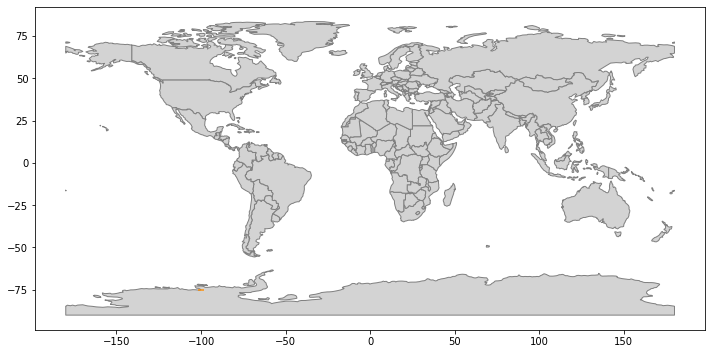

In [4]:
print('product:    ', region.dataset)
print('dates:      ', region.dates)
print('start time: ', region.start_time)
print('end time:   ', region.end_time)
print('version:    ', region.dataset_version)
print('extent:     ', region.spatial_extent)

print('\nDATA:')
print('\n'.join([str(item) for item in region.avail_granules().items()]))

region.visualize_spatial_extent()

Login to Earthdata and download the data files

In [5]:
name = 'fspaolo'
email = 'fspaolo@gmail.com'

# Only download if data folder is empty
if not list(data_home.glob('*.h5')):
    region.earthdata_login(name, email)
    region.download_granules(data_home)

Let's check we got the files we wanted 

In [6]:
files = list(data_home.glob('*.h5'))

for f in files[:10]: print(f)
print('Total number of files:', len(files))

data/ATL06_20190101003047_00540212_209_01.h5
data/ATL06_20190101002504_00540211_209_01.h5
data/ATL06_20190101001723_00540210_209_01.h5
Total number of files: 3


## Reducing ICESat-2 files

> **NOTE:** 
> - This is neither the only nor the best way to handled ICESat-2 data files.
> - This is *one* way that works well for large-scale processing (e.g. full continent) on parallel machines (e.g. HPC clusters).
> - The idea is to (a) simplify the I/O of a complex workflow and (b) take advantage of embarrasingly parallelization.

Let's check the ICESat-2 file structure (!)

In [30]:
file = files[0]
!h5ls -r {file} 

/                        Group
/METADATA                Group
/METADATA/AcquisitionInformation Group
/METADATA/AcquisitionInformation/lidar Group
/METADATA/AcquisitionInformation/lidarDocument Group
/METADATA/AcquisitionInformation/platform Group
/METADATA/AcquisitionInformation/platformDocument Group
/METADATA/DataQuality    Group
/METADATA/DataQuality/CompletenessOmission Group
/METADATA/DataQuality/DomainConsistency Group
/METADATA/DatasetIdentification Group
/METADATA/Extent         Group
/METADATA/Lineage        Group
/METADATA/Lineage/ANC06-01 Group
/METADATA/Lineage/ANC06-02 Group
/METADATA/Lineage/ANC06-03 Group
/METADATA/Lineage/ANC17  Group
/METADATA/Lineage/ANC19  Group
/METADATA/Lineage/ANC25-06 Group
/METADATA/Lineage/ANC26-06 Group
/METADATA/Lineage/ANC28  Group
/METADATA/Lineage/ANC36-06 Group
/METADATA/Lineage/ANC38-06 Group
/METADATA/Lineage/ATL03  Group
/METADATA/Lineage/ATL09  Group
/METADATA/Lineage/Control Group
/METADATA/ProcessStep    Group
/METADATA/ProcessStep/

Let's code a simple reader that:

- Select variables of interest `(x, y, t, h, ...)`  
- Filter data points based on quality flag and bbox   
- Separate into beams and ascending/descending tracks  
- Save data to a simpler HDF5 structure (NOTE: redundancy vs. efficiency)

Some utility functions

In [ ]:
import pyproj
from astropy.time import Time

def gps2dyr(time):
    """ Converte GPS time to decimal years. """
    return Time(time, format='gps').decimalyear


def track_type(time, lat, tmax=1):
    """
    Separate tracks into ascending and descending.
    
    Defines tracks as segments with time breaks > tmax,
    and tests whether lat increases or decreases w/time.
    """
    tracks = np.zeros(lat.shape)  # generate track segment
    tracks[0:np.argmax(np.abs(lat))] = 1  # set values for segment
    i_asc = np.zeros(tracks.shape, dtype=bool)  # output index array

    # Loop trough individual secments
    for track in np.unique(tracks):
    
        i_track, = np.where(track == tracks)  # get all pts from seg
    
        if len(i_track) < 2: continue
    
        # Test if lat increases (asc) or decreases (des) w/time
        i_min = time[i_track].argmin()
        i_max = time[i_track].argmax()
        lat_diff = lat[i_track][i_max] - lat[i_track][i_min]
    
        # Determine track type
        if lat_diff > 0:  i_asc[i_track] = True
    
    return i_asc, np.invert(i_asc)  # index vectors


def transform_coord(proj1, proj2, x, y):
    """
    Transform coordinates from proj1 to proj2 (EPSG num).

    Example EPSG projs:
        Geodetic (lon/lat): 4326
        Polar Stereo AnIS (x/y): 3031
        Polar Stereo GrIS (x/y): 3413
    """
    # Set full EPSG projection strings
    proj1 = pyproj.Proj("+init=EPSG:"+str(proj1))
    proj2 = pyproj.Proj("+init=EPSG:"+str(proj2))
    return pyproj.transform(proj1, proj2, x, y)  # convert


The simple reader

In [ ]:
import h5py
import numpy as np

def read_atl06(fname, bbox=None):
    """Read 1 ATL06 file and output 6 reduced files. 
    
    Extract variables of interest and separate the ATL06 file 
    into each beam (ground track) and ascending/descending orbits.
    """

    # Each beam is a group
    group = ['/gt1l', '/gt1r', '/gt2l', '/gt2r', '/gt3l', '/gt3r']

    # Loop trough beams
    for k, g in enumerate(group):
    
        #-----------------------------------#
        # 1) Read in data for a single beam #
        #-----------------------------------#
    
        # Load variables into memory (add as many as you want)
        with h5py.File(fname, 'r') as fi:
            lat = fi[g+'/land_ice_segments/latitude'][:]
            lon = fi[g+'/land_ice_segments/longitude'][:]
            h_li = fi[g+'/land_ice_segments/h_li'][:]
            s_li = fi[g+'/land_ice_segments/h_li_sigma'][:]
            t_dt = fi[g+'/land_ice_segments/delta_time'][:]
            q_flag = fi[g+'/land_ice_segments/atl06_quality_summary'][:]
            s_fg = fi[g+'/land_ice_segments/fit_statistics/signal_selection_source'][:]
            snr = fi[g+'/land_ice_segments/fit_statistics/snr_significance'][:]
            h_rb = fi[g+'/land_ice_segments/fit_statistics/h_robust_sprd'][:]
            dac = fi[g+'/land_ice_segments/geophysical/dac'][:]
            f_sn = fi[g+'/land_ice_segments/geophysical/bsnow_conf'][:]
            dh_fit_dx = fi[g+'/land_ice_segments/fit_statistics/dh_fit_dx'][:]
            tide_earth = fi[g+'/land_ice_segments/geophysical/tide_earth'][:]
            tide_load = fi[g+'/land_ice_segments/geophysical/tide_load'][:]
            tide_ocean = fi[g+'/land_ice_segments/geophysical/tide_ocean'][:]
            tide_pole = fi[g+'/land_ice_segments/geophysical/tide_pole'][:]
            t_ref = fi['/ancillary_data/atlas_sdp_gps_epoch'][:]
            rgt = fi['/orbit_info/rgt'][:] * np.ones(len(lat))
            orb = np.full_like(h_li, k)
            
            spot = fi[g].attrs["atlas_spot_number"].decode()  # number
            beam = fi[g].attrs["atlas_beam_type"].decode()    # 1=strong/0=weak

        #---------------------------------------------#
        # 2) Filter data according region and quality #
        #---------------------------------------------#
        
        # Select a region of interest
        if bbox:
            lonmin, lonmax, latmin, latmax = bbox
            bbox_mask = (lon >= lonmin) & (lon <= lonmax) & \
                        (lat >= latmin) & (lat <= latmax)
        else:
            bbox_mask = np.ones_like(lat, dtype=bool)  # get all
            
        # Only keep good data, and data inside bbox
        mask = (q_flag == 0) & (np.abs(h_li) < 10e3) & (bbox_mask == 1)
        
        # Update variables
        (lat, lon, h_li, s_li, t_dt, h_rb, s_fg, snr, q_flag, f_sn,
         tide_earth, tide_load, tide_ocean, tide_pole, dac, rgt, orb, spot, beam) = \
               (lat[mask], lon[mask], h_li[mask], s_li[mask], t_dt[mask],
                h_rb[mask], s_fg[mask], snr[mask], q_flag[mask], f_sn[mask],
                tide_earth[mask], tide_load[mask], tide_ocean[mask], tide_pole[mask],
                dac[mask], rgt[mask], orb[mask], spot[mask], beam[mask])
        
        # TODO: stopped here <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<

        # Test for no data
        if len(h_li) == 0: continue

        #-------------------------------------#
        # 3) Convert time and separate tracks #
        #-------------------------------------#
        
        # Time in GPS seconds (secs sinde 1980...)
        t_gps = t_ref + t_dt

        # Time in decimal years
        t_year = gps2dyr(t_gps)

        # Determine orbit type
        i_asc, i_des = track_type(t_year, lat)
        
        #-----------------------#
        # 4) Save selected data #
        #-----------------------#
        
        # Define output file name
        ofile = fname.replace('.h5', '_'+g[1:]+'.h5')
                
        # Save variables
        with h5py.File(ofile, 'w') as f:
            f['orbit'] = orb
            f['lon'] = lon
            f['lat'] = lat
            f['h_elv'] = h_li
            f['t_year'] = t_year
            f['t_sec'] = t_gps
            f['s_elv'] = s_li
            f['h_rb'] = h_rb
            f['s_fg'] = s_fg
            f['snr'] = snr
            f['q_flg'] = q_flag
            f['f_sn'] = f_sn
            f['tide_load'] = tide_load
            f['tide_ocean'] = tide_ocean
            f['tide_pole'] = tide_pole
            f['tide_earth'] = tide_earth
            f['dac'] = dac
            f['rgt'] = rgt
            f['trk_type'] = i_asc

            print('out ->', ofile)
                

## Simple parallelization

* If your problem is embarrasingly parallel, it's easy to parallelize
* We can use the very simple and lightweight `joblib` library
* There is no need to modify your code!

Read more: [https://joblib.readthedocs.io](https://joblib.readthedocs.io)

Let's check the available resources first

In [ ]:
!python system-status.py

In [ ]:
njobs = 3

bbox = None #[-1124782, 81623, -919821, -96334]  # Kamb bounding box

if njobs == 1:
    print('running in serial ...')
    [read_atl06(f, bbox) for f in files]

else:
    print('running in parallel (%d jobs) ...' % njobs)
    from joblib import Parallel, delayed
    Parallel(n_jobs=njobs, verbose=5)(delayed(read_atl06)(f, bbox) for f in files)


Let's check our created files

In [ ]:
!ls data/*.h5

In [ ]:
!h5ls -r data/ATL06_20190101001723_00540210_209_01_gt1l.h5

## Plot some data to check

* Plot track points within region to check
* Plot track/beam profiles to check

Reading data now becomes trivial!!!

In [ ]:
import matplotlib.pyplot as plt

def read_h5(fname, vnames=[]):
    """ Simple HDF5 reader. """
    with h5py.File(fname, 'r') as f:
        return [f[v][:] for v in vnames]

    
files = list_files_local('data/ATL06_20190101002504_00540211_209_01_gt*')

fig = plt.figure(figsize=(14,5))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

for fname in files:

    lon, lat, t, h = read_h5(fname, ['lon', 'lat', 't_year', 'h_elv'])
    
    x, y = transform_coord(4326, 3031, lon, lat)
 
    ax1.plot(x, y, '.', label='%s' % fname[-7:-3])
    ax2.plot(t, h, '.', label='%s' % fname[-7:-3])
    
ax1.set_xlabel('x (m)')
ax1.set_ylabel('y (m)')
ax1.legend()
ax2.set_xlabel('time (yr)')
ax2.set_ylabel('height (m)')
ax2.legend()
plt.show();
    

## Single program from the command line

You can put all of the above (and more) into a single script and run it on the command line:

In [ ]:
!python readatl06.py -h

Try reading the ICESat-2 files in parallel from the command line:

In [ ]:
!python readatl06.py data/*_01.h5 -n 3

In [ ]:
!cat readatl06.py